## Regularised Logistic Regression

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import beepy 

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, GridSearchCV 
from sklearn.preprocessing import PolynomialFeatures

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc

/var/folders/jv/l_04ggr950q_nbs9_jfgsydc0000gn/T/ipykernel_86109/4046485158.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
default_data = pd.read_csv('Loan_default.csv')
default_data.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [3]:
default_data.drop('LoanID', axis=1, inplace=True)

In [4]:
default_train, default_test = train_test_split(
                                                default_data, test_size = 0.3, random_state = 42, 
                                                stratify = default_data["Default"]) 

In [5]:
df_majority = default_train[default_train["Default"] == 0] 
df_minority = default_train[default_train["Default"] == 1] 

df_majority_downsampled = df_majority.sample(n = len(df_minority), random_state = 42)

default_train_downsampled = pd.concat([df_majority_downsampled, df_minority])

default_train_downsampled = default_train_downsampled.sample(frac = 1, random_state = 42)

n = default_train_downsampled["Default"].value_counts()
prop = n/len(default_train_downsampled)

print(prop)

Default
1    0.5
0    0.5
Name: count, dtype: float64


In [6]:
default_train_downsampled.head(5)

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
187975,53,32801,66006,803,67,1,13.94,12,0.40,High School,Full-time,Single,No,Yes,Education,No,1
87117,66,64139,82419,677,106,1,23.25,24,0.28,Bachelor's,Part-time,Single,Yes,No,Home,Yes,0
87211,46,58788,85955,568,71,1,11.70,36,0.55,Bachelor's,Full-time,Divorced,Yes,Yes,Auto,Yes,0
75326,38,145818,58555,648,96,1,15.38,60,0.23,Master's,Full-time,Single,No,No,Auto,No,1
188966,19,94405,237790,398,35,3,4.88,12,0.62,Master's,Part-time,Divorced,No,No,Home,Yes,1


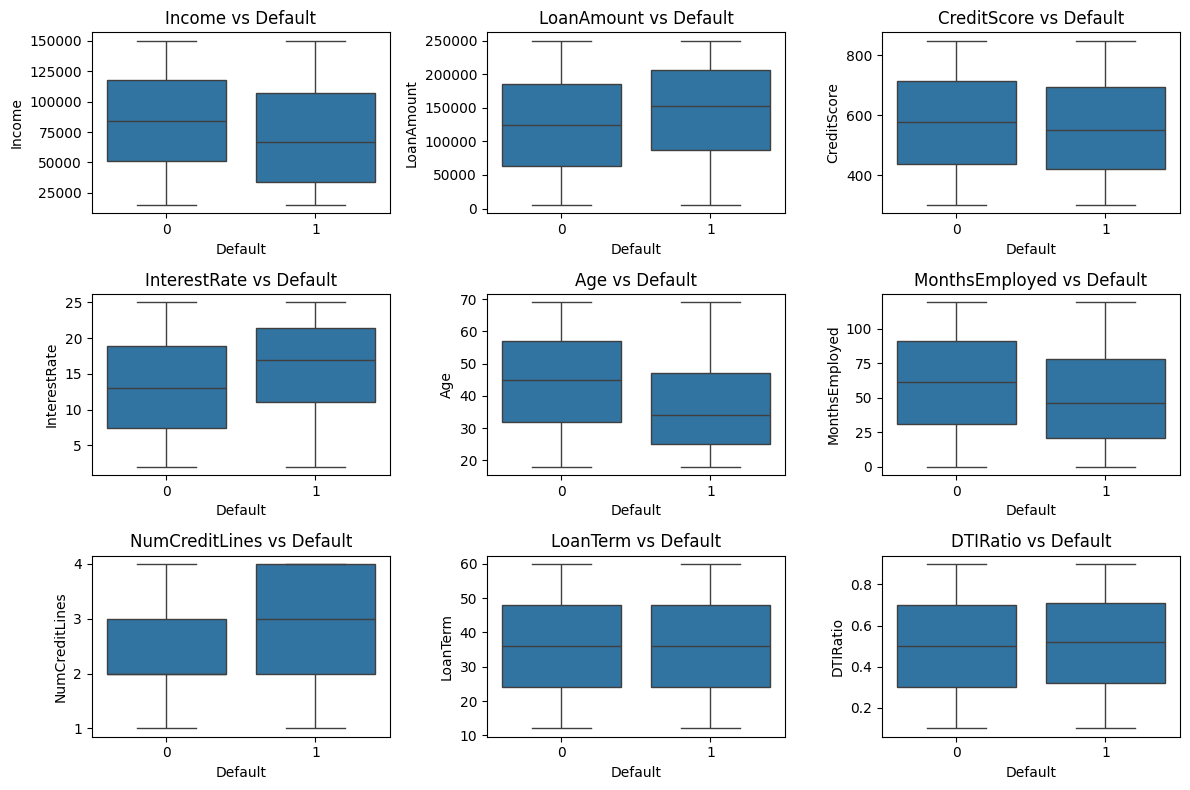

In [7]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))

# Plot the boxplots
sns.boxplot(x='Default', y='Income', data=default_train_downsampled, ax=axes[0, 0]) #Income
sns.boxplot(x='Default', y='LoanAmount', data=default_train_downsampled, ax=axes[0, 1]) #LoanAmount
sns.boxplot(x='Default', y='CreditScore', data=default_train_downsampled, ax=axes[0, 2]) #CreditScore
sns.boxplot(x='Default', y='InterestRate', data=default_train_downsampled, ax=axes[1, 0]) #InterestRate
sns.boxplot(x='Default', y='Age', data=default_train_downsampled, ax=axes[1, 1])    #Age
sns.boxplot(x='Default', y='MonthsEmployed', data=default_train_downsampled, ax=axes[1, 2]) #MonthsEmployed
sns.boxplot(x='Default', y='NumCreditLines', data=default_train_downsampled, ax=axes[2, 0]) #NumCreditLines
sns.boxplot(x='Default', y='LoanTerm', data=default_train_downsampled, ax=axes[2, 1]) #LoanTerm
sns.boxplot(x='Default', y='DTIRatio', data=default_train_downsampled, ax=axes[2, 2]) #DTI

# Set titles for each subplot
axes[0, 0].set_title('Income vs Default')
axes[0, 1].set_title('LoanAmount vs Default')
axes[0,2].set_title('CreditScore vs Default')
axes[1, 0].set_title('InterestRate vs Default')
axes[1, 1].set_title('Age vs Default')
axes[1, 2].set_title('MonthsEmployed vs Default')
axes[2, 0].set_title('NumCreditLines vs Default')
axes[2, 1].set_title('LoanTerm vs Default')
axes[2, 2].set_title('DTIRatio vs Default')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


In [8]:
#Creating a preprocessing function to be applied to the training and testing sets:
def preprocess_data(df):
    
    # Convert Yes/No to 1/0: 
    df['mortgage'] = df['HasMortgage'].replace({'Yes': 1, 'No': 0})
    df['dependents'] = df['HasDependents'].replace({'Yes': 1, 'No': 0})
    df['cosigners'] = df['HasCoSigner'].replace({'Yes': 1, 'No': 0})

    #New variables:
    df['Debt'] = df['Income'] * df['DTIRatio']
    df['IneterestRatePayments'] = df['LoanAmount'] * df['InterestRate']
    
    #Convert 'Education' to ordinal:
    educ_order = {"High School": 1, "Bachelor's": 2, "Master's": 3, "PhD": 4}
    df['Educ'] = df['Education'].replace(educ_order)
    df.drop('Education', axis=1, inplace=True)
    
    # One-Hot Encoding: 
    emp = pd.get_dummies(df['EmploymentType'],drop_first=True)
    marital_status = pd.get_dummies(df['MaritalStatus'], drop_first=True)
    loan_purpose = pd.get_dummies(df['LoanPurpose'], drop_first=True)

    # Concatenate og df with new dummy vars:
    df = pd.concat([df, emp, marital_status, loan_purpose], axis=1)

    # Drop old columns; 
    columns_to_drop = ['HasMortgage','Education', 'HasDependents', 'HasCoSigner', 'EmploymentType', 'MaritalStatus', 'LoanPurpose']
    df.drop(columns=columns_to_drop, axis=1, inplace=True)

    # Create interaction terms:
    df['AgeIncome'] = df['Age'] * df['Income']
    df['AgeLoanAmount'] = df['Age'] * df['LoanAmount']
    df['AgeCreditScore'] = df['Age'] * df['CreditScore']
    df['AgeNumCreditLines'] = df['Age'] * df['NumCreditLines']
    df['AgeInterestRate'] = df['Age'] * df['InterestRate']
    df['AgeDTIRatio'] = df['Age'] * df['DTIRatio']
    df['AgeDebt'] = df['Age'] * df['Debt']

    df['IncomeLoanAmount'] = df['Income'] * df['LoanAmount']
    df['IncomeCreditScore'] = df['Income'] * df['CreditScore']
    df['IncomeMonthsEmployed'] = df['Income'] * df['MonthsEmployed']
    df['IncomeNumCreditLines'] = df['Income'] * df['NumCreditLines']
    df['IncomeInetersRate'] = df['Income'] * df['InterestRate']
    df['IncomeDTIRatio'] = df['Income'] * df['DTIRatio']
    df['IncomeDebt'] = df['Income'] * df['Debt']
    df['IncomeInterestRatePayments'] = df['Income'] * df['IneterestRatePayments']

    df['LoanAmountCreditScore'] = df['LoanAmount'] * df['CreditScore']
    df['LoanAmountNumCreditLines'] = df['LoanAmount'] * df['NumCreditLines']
    df['LoanAmountInterestRate'] = df['LoanAmount'] * df['InterestRate']
    df['LoanAmountDTIRatio'] = df['LoanAmount'] * df['DTIRatio']
    df['LoanAmountDebt'] = df['LoanAmount'] * df['Debt']
    df['LoanAmountInterestRatePayments'] = df['LoanAmount'] * df['IneterestRatePayments']

    df['CreditScoreNumCreditLines'] = df['CreditScore'] * df['NumCreditLines']
    df['CreditScoreInterestRate'] = df['CreditScore'] * df['InterestRate']
    df['CreditScoreDTIRatio'] = df['CreditScore'] * df['DTIRatio']
    df['CreditScoreDebt'] = df['CreditScore'] * df['Debt']
    df['CreditScoreInterestRatePayments'] = df['CreditScore'] * df['IneterestRatePayments']

    df['MonthsEmployedNumCreditLines'] = df['MonthsEmployed'] * df['NumCreditLines']
    df['MonthsEmployedLoanTerm'] = df['MonthsEmployed'] * df['LoanTerm']
    df['MonthsEmployedDebt'] = df['MonthsEmployed'] * df['Debt']
    df['MonthsEmployedInterestRatePayments'] = df['MonthsEmployed'] * df['IneterestRatePayments']

    df['NumCreditLinesInterestRate'] = df['NumCreditLines'] * df['InterestRate']
    df['NumCreditLinesDTIRatio'] = df['NumCreditLines'] * df['DTIRatio']
    df['NumCreditLinesDebt'] = df['NumCreditLines'] * df['Debt']
    df['NumCreditLinesInterestRatePayments'] = df['NumCreditLines'] * df['IneterestRatePayments']

    df['InterestRateDTIRatio'] = df['InterestRate'] * df['DTIRatio']
    df['InterestRateDebt'] = df['InterestRate'] * df['Debt']

    df['DebtInterestRate'] = df['Debt'] * df['InterestRate']

    return df

In [9]:
preprocessed_df = preprocess_data(default_train_downsampled)
preprocessed_df.head(5)

/var/folders/jv/l_04ggr950q_nbs9_jfgsydc0000gn/T/ipykernel_86109/2961113696.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['mortgage'] = df['HasMortgage'].replace({'Yes': 1, 'No': 0})
/var/folders/jv/l_04ggr950q_nbs9_jfgsydc0000gn/T/ipykernel_86109/2961113696.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['dependents'] = df['HasDependents'].replace({'Yes': 1, 'No': 0})
/var/folders/jv/l_04ggr950q_nbs9_jfgsydc0000gn/T/ipykernel_86109/2961113696.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default,...,MonthsEmployedLoanTerm,MonthsEmployedDebt,MonthsEmployedInterestRatePayments,NumCreditLinesInterestRate,NumCreditLinesDTIRatio,NumCreditLinesDebt,NumCreditLinesInterestRatePayments,InterestRateDTIRatio,InterestRateDebt,DebtInterestRate
187975,53,32801,66006,803,67,1,13.94,12,0.40,1,...,804,879066.80,6.164828e+07,13.94,0.40,13120.40,920123.64,5.5760,182898.3760,182898.3760
87117,66,64139,82419,677,106,1,23.25,24,0.28,0,...,2544,1903645.52,2.031216e+08,23.25,0.28,17958.92,1916241.75,6.5100,417544.8900,417544.8900
87211,46,58788,85955,568,71,1,11.70,36,0.55,0,...,2556,2295671.40,7.140282e+07,11.70,0.55,32333.40,1005673.50,6.4350,378300.7800,378300.7800
75326,38,145818,58555,648,96,1,15.38,60,0.23,1,...,5760,3219661.44,8.645529e+07,15.38,0.23,33538.14,900575.90,3.5374,515816.5932,515816.5932
188966,19,94405,237790,398,35,3,4.88,12,0.62,1,...,420,2048588.50,4.061453e+07,14.64,1.86,175593.30,3481245.60,3.0256,285631.7680,285631.7680


In [10]:
preprocessed_df['Default'].value_counts()

Default
1    20757
0    20757
Name: count, dtype: int64

In [11]:
preprocessed_df.columns.tolist()

['Age',
 'Income',
 'LoanAmount',
 'CreditScore',
 'MonthsEmployed',
 'NumCreditLines',
 'InterestRate',
 'LoanTerm',
 'DTIRatio',
 'Default',
 'mortgage',
 'dependents',
 'cosigners',
 'Debt',
 'IneterestRatePayments',
 'Educ',
 'Part-time',
 'Self-employed',
 'Unemployed',
 'Married',
 'Single',
 'Business',
 'Home',
 'Other',
 'AgeIncome',
 'AgeLoanAmount',
 'AgeCreditScore',
 'AgeNumCreditLines',
 'AgeInterestRate',
 'AgeDTIRatio',
 'AgeDebt',
 'IncomeLoanAmount',
 'IncomeCreditScore',
 'IncomeMonthsEmployed',
 'IncomeNumCreditLines',
 'IncomeInetersRate',
 'IncomeDTIRatio',
 'IncomeDebt',
 'IncomeInterestRatePayments',
 'LoanAmountCreditScore',
 'LoanAmountNumCreditLines',
 'LoanAmountInterestRate',
 'LoanAmountDTIRatio',
 'LoanAmountDebt',
 'LoanAmountInterestRatePayments',
 'CreditScoreNumCreditLines',
 'CreditScoreInterestRate',
 'CreditScoreDTIRatio',
 'CreditScoreDebt',
 'CreditScoreInterestRatePayments',
 'MonthsEmployedNumCreditLines',
 'MonthsEmployedLoanTerm',
 'MonthsEmp

In [12]:
cv_folds = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
cv_folds

StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

### Regularised Logistic Regressions

In [13]:
#Normalising the features:
scaler = StandardScaler()

#Train test splits:
X = preprocessed_df.drop('Default', axis=1)
y = preprocessed_df['Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test) #done later


In [14]:
lasso = LogisticRegression(penalty='l1', solver='saga', random_state=42)
#Print parameters:
print(lasso.get_params())

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [15]:
param_grid = {'C': list(np.logspace(-2, 0, 15))}
param_grid

{'C': [0.01,
  0.013894954943731374,
  0.019306977288832496,
  0.02682695795279726,
  0.0372759372031494,
  0.0517947467923121,
  0.07196856730011521,
  0.1,
  0.13894954943731375,
  0.19306977288832497,
  0.2682695795279725,
  0.372759372031494,
  0.517947467923121,
  0.7196856730011517,
  1.0]}

In [16]:
import warnings

#Supress some warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [17]:
lasso_grid_search = GridSearchCV(lasso, param_grid, cv=cv_folds, scoring='recall', return_train_score=True)
lasso_grid_search.fit(X_train, y_train)

/Users/Francho/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Francho/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Francho/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Francho/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=LogisticRegression(penalty='l1', random_state=42,
                                          solver='saga'),
             param_grid={'C': [0.01, 0.013894954943731374, 0.019306977288832496,
                               0.02682695795279726, 0.0372759372031494,
                               0.0517947467923121, 0.07196856730011521, 0.1,
                               0.13894954943731375, 0.19306977288832497,
                               0.2682695795279725, 0.372759372031494,
                               0.517947467923121, 0.7196856730011517, 1.0]},
             return_train_score=True, scoring='recall')

In [18]:
import beepy 
beepy.beep(sound=6)

In [19]:
lasso_grid_search.best_params_

{'C': 0.013894954943731374}

In [20]:
lasso_grid_search_results = pd.DataFrame(lasso_grid_search.cv_results_).sort_values('mean_test_score', ascending=False)
lasso_grid_search_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
1,0.436075,0.027329,0.029390,0.040968,0.013895,{'C': 0.013894954943731374},0.679325,0.677517,0.679325,0.699819,...,0.693122,0.692586,0.693189,0.691849,0.693323,0.692251,0.692385,0.691916,0.692827,0.000696
2,0.423332,0.056527,0.015284,0.013304,0.019307,{'C': 0.019306977288832496},0.679928,0.675105,0.676311,0.701627,...,0.693189,0.691916,0.692653,0.691782,0.693122,0.690644,0.691648,0.691112,0.692177,0.000848
0,0.434731,0.052770,0.020034,0.016141,0.01,{'C': 0.01},0.676914,0.679928,0.678119,0.699819,...,0.692452,0.691514,0.692854,0.690845,0.692988,0.691849,0.691648,0.690108,0.692037,0.000987
3,0.566130,0.119518,0.015679,0.009333,0.026827,{'C': 0.02682695795279726},0.679325,0.673297,0.675105,0.699819,...,0.691581,0.691380,0.690778,0.689840,0.691179,0.690711,0.689237,0.690778,0.690818,0.000719
4,0.602707,0.074190,0.019474,0.008189,0.037276,{'C': 0.0372759372031494},0.677517,0.672092,0.673900,0.694997,...,0.690041,0.689170,0.688701,0.689036,0.689170,0.689438,0.688768,0.689371,0.689277,0.000425
5,0.613330,0.074155,0.011070,0.005753,0.051795,{'C': 0.0517947467923121},0.676311,0.669078,0.672694,0.694997,...,0.689036,0.687161,0.688300,0.687764,0.688835,0.687362,0.687764,0.688634,0.688212,0.000654
8,0.769500,0.075116,0.017090,0.012497,0.13895,{'C': 0.13894954943731375},0.674503,0.669078,0.673900,0.696203,...,0.689170,0.687965,0.687630,0.687295,0.688300,0.687496,0.686960,0.688634,0.688065,0.000708
6,0.612503,0.060646,0.011333,0.005285,0.071969,{'C': 0.07196856730011521},0.672092,0.670886,0.671489,0.694997,...,0.689572,0.687228,0.687496,0.687362,0.688099,0.687094,0.687027,0.688366,0.687985,0.000833
12,1.574616,0.193448,0.013458,0.004850,0.517947,{'C': 0.517947467923121},0.678119,0.669681,0.672092,0.694394,...,0.689773,0.688032,0.687228,0.686558,0.687965,0.687831,0.687161,0.688500,0.688112,0.000944
13,1.888768,0.194370,0.012815,0.006142,0.719686,{'C': 0.7196856730011517},0.678722,0.669681,0.672092,0.694394,...,0.689773,0.688032,0.687496,0.686625,0.687764,0.687429,0.687831,0.688500,0.688186,0.000957


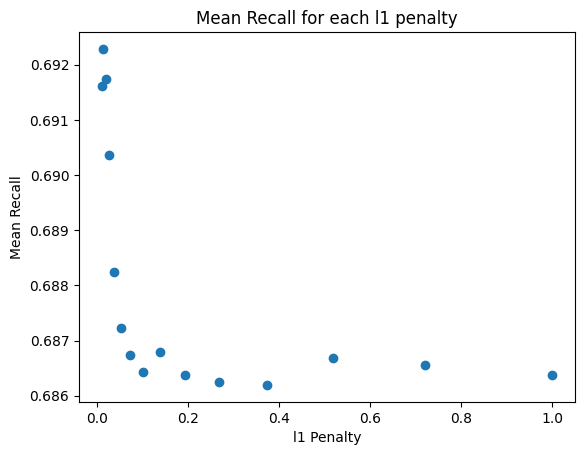

In [21]:
#Visualize mean score for each C value:
plt.scatter(lasso_grid_search_results['param_C'], lasso_grid_search_results['mean_test_score'])
plt.xlabel('l1 Penalty')
plt.ylabel('Mean Recall')
plt.title('Mean Recall for each l1 penalty')
plt.show()

In [22]:
#Select the best model:
final_lasso = lasso_grid_search.best_estimator_
final_lasso

LogisticRegression(C=0.013894954943731374, penalty='l1', random_state=42,
                   solver='saga')

In [23]:
final_lasso.fit(X_train, y_train)

LogisticRegression(C=0.013894954943731374, penalty='l1', random_state=42,
                   solver='saga')

In [24]:
#Storing columns names:
column_names = X.columns.tolist()
#Storing index of X_test:
X_test_index = X_test.index
#Normalising the test set:
X_test= scaler.transform(X_test)
#Converting X_test back to a DataFrame:
X_test = pd.DataFrame(X_test, columns=column_names, index=X_test_index)

#Predicting probabilities:
y_pred = final_lasso.predict(X_test)


/Users/Francho/Library/Python/3.10/lib/python/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [25]:
conf_matrix = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred) 
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test,y_pred)

# Evaluation metrics:
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {acc:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

Confusion Matrix:
[[2740 1396]
 [1279 2888]]
Accuracy: 0.6778
Sensitivity (Recall): 0.6931
Precision: 0.6741
F1 Score: 0.6835


/Users/Francho/Library/Python/3.10/lib/python/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


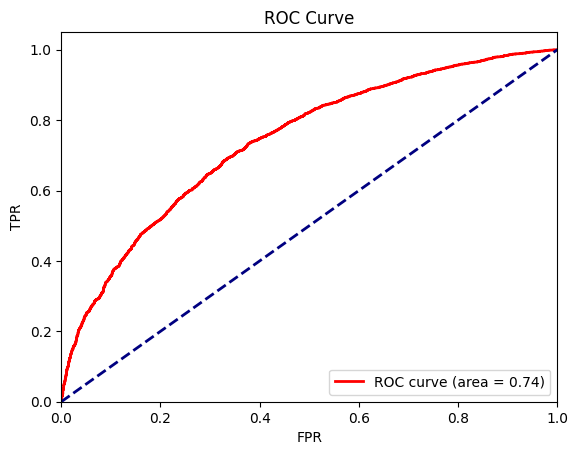

In [26]:
# ROC Curve and AUC score: 

#soft probabilities: 
y_scores = final_lasso.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot:
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') #random model
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [27]:
feature_importances = final_lasso.coef_.flatten()
feature_names = X.columns.tolist()

# Create a dataframe to display the feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)


                               Feature  Importance
2                           LoanAmount    0.416780
6                         InterestRate    0.382921
36                          IncomeDebt    0.232728
17                          Unemployed    0.157940
41                  LoanAmountDTIRatio    0.097840
53          NumCreditLinesInterestRate    0.093907
15                           Part-time    0.086766
16                       Self-employed    0.076940
20                            Business    0.030737
43      LoanAmountInterestRatePayments    0.025934
39            LoanAmountNumCreditLines    0.007441
54              NumCreditLinesDTIRatio    0.007340
5                       NumCreditLines    0.005358
59                    DebtInterestRate    0.000000
40              LoanAmountInterestRate    0.000000
38               LoanAmountCreditScore    0.000000
34                   IncomeInetersRate    0.000000
37          IncomeInterestRatePayments    0.000000
44           CreditScoreNumCred

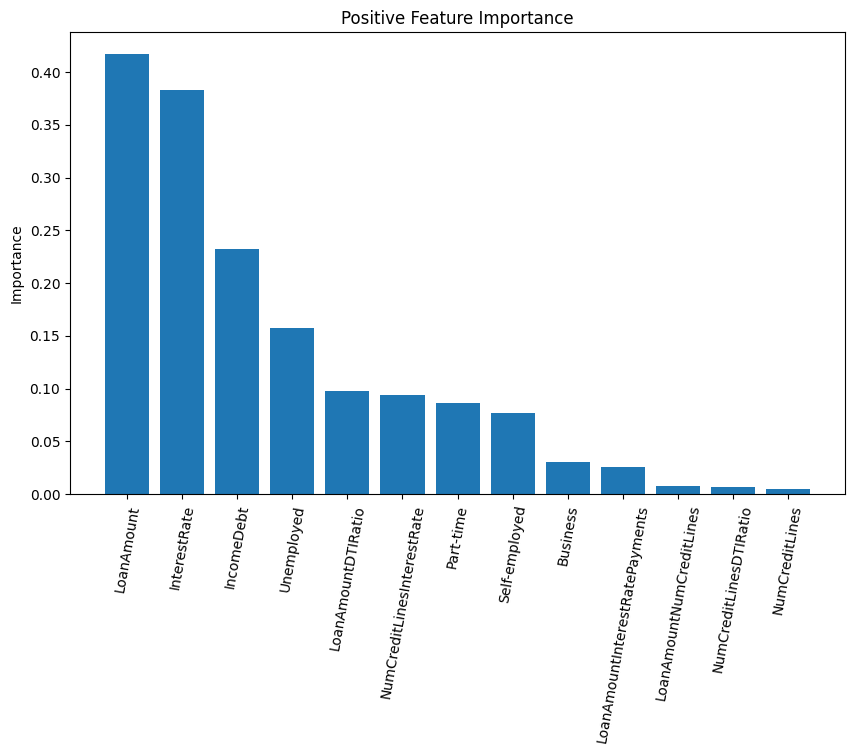

In [28]:
pos_feature_importances = importance_df[importance_df['Importance'] > 0]
# Plot the bar chart:
plt.figure(figsize=(10, 6))
plt.bar(pos_feature_importances['Feature'], pos_feature_importances['Importance'])
plt.ylabel('Importance')
plt.title('Positive Feature Importance')
plt.xticks(rotation=80)
plt.show()


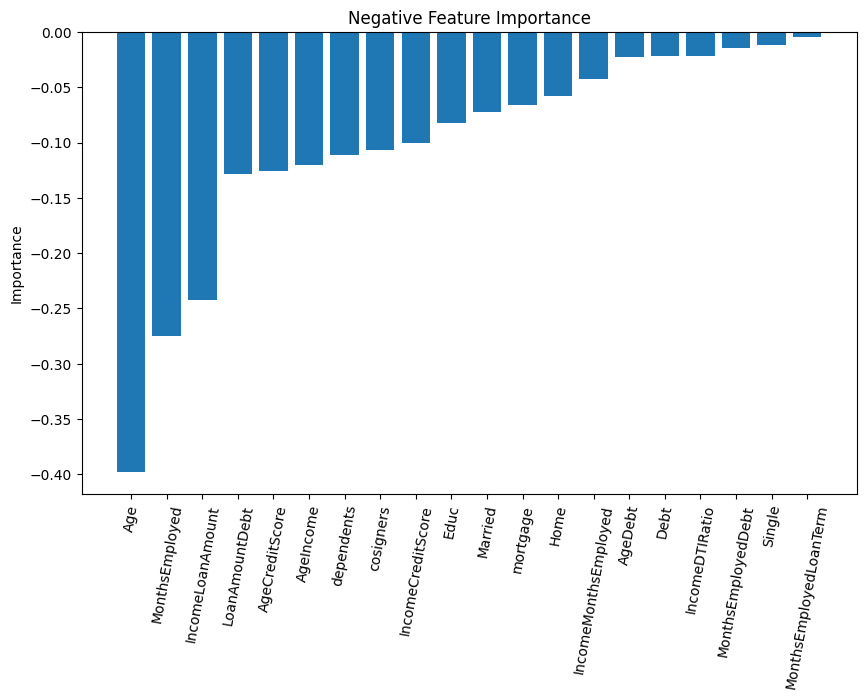

In [29]:
neg_feature_importances = importance_df[importance_df['Importance'] < 0].sort_values(by='Importance', ascending=True)
# Plot the bar chart:
plt.figure(figsize=(10, 6))
plt.bar(neg_feature_importances['Feature'], neg_feature_importances['Importance'])
plt.ylabel('Importance')
plt.title('Negative Feature Importance')
plt.xticks(rotation=80)
plt.show()